# Build a linear model with Estimators

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/estimator/linear"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/estimator/linear.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/estimator/linear.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/estimator/linear.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

This end-to-end walkthrough trains a logistic regression model using the `tf.estimator` API. The model is often used as a baseline for other, more complex, algorithms.


## Setup

In [1]:
!pip install -q sklearn

In [2]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

## Load the titanic dataset
You will use the Titanic dataset with the (rather morbid) goal of predicting passenger survival, given characteristics such as gender, age, class, etc.

In [3]:
import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

In [4]:
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

## Explore the data

The dataset contains the following features

In [5]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [6]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


There are 627 and 264 examples in the training and evaluation sets, respectively.

In [7]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

The majority of passengers are in their 20's and 30's.

<AxesSubplot:>

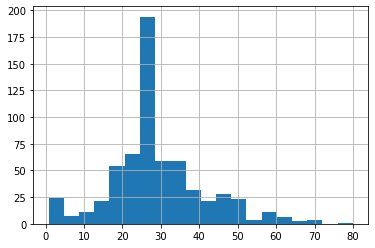

In [8]:
dftrain.age.hist(bins=20)

There are approximately twice as many male passengers as female passengers aboard.

<AxesSubplot:>

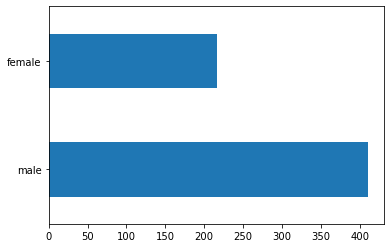

In [9]:
dftrain.sex.value_counts().plot(kind='barh')

The majority of passengers were in the "third" class.

<AxesSubplot:>

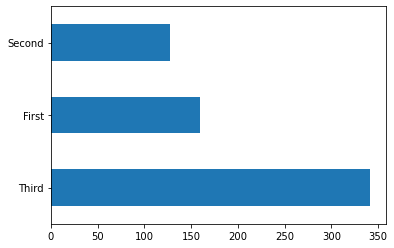

In [10]:
dftrain['class'].value_counts().plot(kind='barh')

Females have a much higher chance of surviving versus males. This is clearly a predictive feature for the model.

Text(0.5, 0, '% survive')

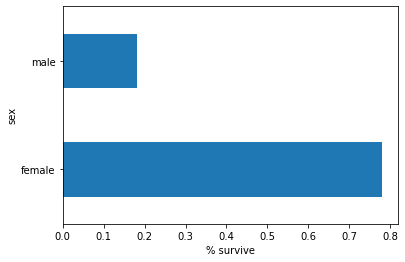

In [11]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

## Feature Engineering for the Model
Estimators use a system called [feature columns](https://www.tensorflow.org/guide/feature_columns) to describe how the model should interpret each of the raw input features. An Estimator expects a vector of numeric inputs, and *feature columns* describe how the model should convert each feature.

Selecting and crafting the right set of feature columns is key to learning an effective model. A feature column can be either one of the raw inputs in the original features `dict` (a *base feature column*), or any new columns created using transformations defined over one or multiple base columns (a *derived feature columns*).

The linear estimator uses both numeric and categorical features. Feature columns work with all TensorFlow estimators and their purpose is to define the features used for modeling. Additionally, they provide some feature engineering capabilities like one-hot-encoding, normalization, and bucketization.

### Base Feature Columns

In [12]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

The `input_function` specifies how data is converted to a `tf.data.Dataset` that feeds the input pipeline in a streaming fashion. `tf.data.Dataset` can take in multiple sources such as a dataframe, a csv-formatted file, and more.

In [13]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

You can inspect the dataset:

In [14]:
ds = make_input_fn(dftrain, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
  print('Some feature keys:', list(feature_batch.keys()))
  print()
  print('A batch of class:', feature_batch['class'].numpy())
  print()
  print('A batch of Labels:', label_batch.numpy())

Some feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

A batch of class: [b'Third' b'First' b'First' b'Third' b'Third' b'First' b'Second' b'Third'
 b'Third' b'Third']

A batch of Labels: [0 1 0 1 1 1 1 0 0 0]


You can also inspect the result of a specific feature column using the `tf.keras.layers.DenseFeatures` layer:

In [15]:
age_column = feature_columns[7]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[20.],
       [45.],
       [37.],
       [29.],
       [ 4.],
       [35.],
       [30.],
       [48.],
       [28.],
       [43.]], dtype=float32)

`DenseFeatures` only accepts dense tensors, to inspect a categorical column you need to transform that to a indicator column first:

In [16]:
gender_column = feature_columns[0]
tf.keras.layers.DenseFeatures([tf.feature_column.indicator_column(gender_column)])(feature_batch).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

After adding all the base features to the model, let's train the model. Training a model is just a single command using the `tf.estimator` API:

In [17]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.75, 'accuracy_baseline': 0.625, 'auc': 0.83174163, 'auc_precision_recall': 0.78713256, 'average_loss': 0.49030703, 'label/mean': 0.375, 'loss': 0.48477513, 'precision': 0.6486486, 'prediction/mean': 0.4348913, 'recall': 0.72727275, 'global_step': 200}


### Derived Feature Columns

Now you reached an accuracy of 75%. Using each base feature column separately may not be enough to explain the data. For example, the correlation between gender and the label may be different for different gender. Therefore, if you only learn a single model weight for `gender="Male"` and `gender="Female"`, you won't capture every age-gender combination (e.g. distinguishing between `gender="Male"` AND `age="30"` AND `gender="Male"` AND `age="40"`).

To learn the differences between different feature combinations, you can add *crossed feature columns* to the model (you can also bucketize age column before the cross column):

In [18]:
age_x_gender = tf.feature_column.crossed_column(['age', 'sex'], hash_bucket_size=100)

After adding the combination feature to the model, let's train the model again:

In [19]:
derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns+derived_feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.7537879, 'accuracy_baseline': 0.625, 'auc': 0.84658706, 'auc_precision_recall': 0.7863903, 'average_loss': 0.4716316, 'label/mean': 0.375, 'loss': 0.4645122, 'precision': 0.6603774, 'prediction/mean': 0.4101884, 'recall': 0.7070707, 'global_step': 200}


It now achieves an accuracy of 77.6%, which is slightly better than only trained in base features. You can try using more features and transformations to see if you can do better!

Now you can use the train model to make predictions on a passenger from the evaluation set. TensorFlow models are optimized to make predictions on a batch, or collection, of examples at once. Earlier,  the `eval_input_fn` was  defined using the entire evaluation set.

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Eugenio\AppData\Local\Temp\tmpk5aq7gyf\model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


<AxesSubplot:title={'center':'predicted probabilities'}, ylabel='Frequency'>

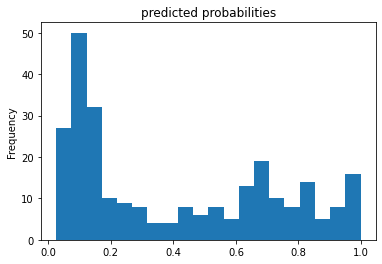

In [20]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

Finally, look at the receiver operating characteristic (ROC) of the results, which will give us a better idea of the tradeoff between the true positive rate and false positive rate.

(0.0, 1.05)

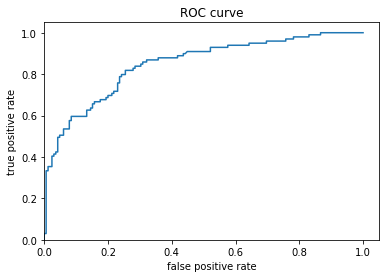

In [21]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)